This code creates a time-dependent OU process class with the following parameterization:

$dX_{t} = [-\frac{a}{at+b}X_{t} - (ct+d)] dt + dW_{t}$

where their transition densitiy is a Gaussian distribution,

$x_{t}|x_{s};\lambda \sim N(\mu(x_{s};\lambda), \sigma^{2}(\lambda))$

where 

$\mu(x_{s}) = \frac{as+b}{at+b}[x_{s} + \frac{1}{as+b}(\frac{ac}{3}(t^{3} - s^{3})+\frac{ad+bc}{2}(t^{2} - s^{2}) + db(t-s))]$

$\sigma^{2}(\lambda) = \frac{\sigma^{2}}{(as+b)^{2}}[\frac{a^{2}}{3}(t^{3} - s^{3}) + ab(t^{2} - s^{2}) + b^{2}(t-s)](\frac{as+b}{at+b})^{2} > 0$ 

A series of experiments show that one can obtain MLE based on a vanila gradient descent algorithm without facing any numerical stability issue. For instance, the gradient descent algorithm applied to every parameter leads to the convergence of all these parameters. It is because the both conditional mean and variance is valid regardless of the associated parameter values. 

In [234]:
import torch
import numpy as np
from torch.autograd import Variable
from torch.distributions import Normal


class tOU:
    def __init__(self, t0, t1, parameters, sde_sigma, init_dist, timegrid=False, dN=200):
        """
            t0, t1 = torch.tensor(t1)
            alpha, beta, m0, r, sigma = torch.tensor.shape (D, 1)
        """
        assert all(sigma > 0), "variance must be positive"
        
        self.t0 = t0
        self.t1 = t1
        
        # set parameters
        self.a = parameters['a']
        self.b = parameters['b']
        self.c = parameters['c']
        self.d = parameters['d']
        
        # set hyper-parameter
        self.sigma = sde_sigma
        
        D = self.a.shape[0]
        if timegrid == True:
            self.pts = torch.linspace(t0, t1, dN).repeat(D, 1)
        else:
            self.pts = torch.sort(torch.cat([(t1 - t0) * torch.rand(D, dN-2) + t0, torch.tensor([self.t0, self.t1]).repeat(D,1)], axis=1), axis=1)[0]
            
        self.trj, self.dt = self.path(init_dist)
        
            
    def path(self, init_dist):
        """
            init_dist: distribution to draw an initial state
            init_dist = Normal(loc=E[X_{t_{i-1}}|lambda_{i-1}], scale = std[X_{t_{i-1}}|lambda_{i-1}])
        """
        
        # Get parameters

        a = self.a
        b = self.b
        c = self.c
        d = self.d
        
        sigma = self.sigma
        
        t = self.pts
        
        
        def mean(x, t0, a, b, c, d):
            """
                t0: we always start our process from t = 0
            """
            s = t0[:, 0].reshape(-1, 1)
            t = t0[:, 1].reshape(-1, 1)
            
            b_t = -1 / (a*s + b) * (a*c*(t**3 - s**3)/3 + (a*d + b*c)*(t**2 - s**2)/2 + d*b*(t-s))

            return (x.reshape(-1, 1) - b_t) * (a*s + b) / (a * t + b)
        
        def variance(t0, a, b, sigma):
            s = t0[:, :-1]
            t = t0[:, 1:]
            
            term1 = sigma**2/(a*s + b)**2
            term2 = a**2 * (t**3 - s**3)/3 + a*b*(t**2 - s**2) + b**2 * (t-s)
            term3 = ((a*s + b)/(a*t + b)) ** 2
            return term1 * term2 * term3 
        
        def std(t, a, b, sigma):
            return torch.sqrt(variance(t, a, b, sigma))

        
        normal = Normal(loc=0., scale=1.)
        x = normal.sample(t.size())

        if type(init_dist) == torch.distributions.normal.Normal:
            # sample initial state from approximate posterior distribution
            m0 = init_dist.sample([x.shape[0], 1])
            x[:, 0] = m0.flatten()
        else:
            m0 = init_dist
            x[:, 0] = m0.flatten()
            
        t0 = t - t[:, 0].reshape(-1, 1)

        dt = torch.diff(t)

        scale = std(t, a, b, sigma)
        x[:, 1:] = x[:, 1:] * scale
        for i in range(1, x.shape[1]):
            x[:, i] += mean(x[:, i-1], t0[:, i-1:i+1], a, b, c, d).flatten()
        
        return x, dt


In [235]:
dist = Normal(loc=0, scale=1.)
t0 = torch.tensor(1.)
t1 = torch.tensor(2.)
sigma = torch.tensor([1.]).reshape(-1, 1)

In [236]:
parameters = {'a': torch.tensor([0.05]).reshape(-1, 1), \
             'b': torch.tensor([0.8]).reshape(-1, 1), \
             'c': torch.tensor([0.05]).reshape(-1, 1), \
             'd': torch.tensor([1.0]).reshape(-1, 1)}

In [237]:
init_pts = torch.tensor([1.0]).reshape(-1, 1)

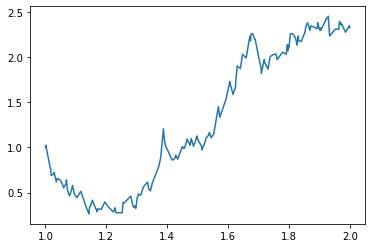

In [238]:
tou = tOU(t0, t1, parameters, sigma, init_dist=init_pts)

import matplotlib.pylab as plt

plt.plot(tou.pts.T, tou.trj.T)

In [239]:
def tou_gradient(pts, x, params, sde_sigma, init_dist):
    assert torch.is_tensor(sde_sigma), "sde_sigma must be a (D*1) tensor"
    assert torch.is_tensor(init_dist) or type(init_dist) == torch.distributions.normal.Normal,\
    "init_dist must either be tensor or torch.distributions"
    
    """
        Calculates log likelihood of a path
        Note that there are three parameters, alpha, beta, r
    """
    
    def mean(x, time, a, b, c, d):
        """
            t0: we always start our process from t = 0
        """
        t0 = time - time[:, 0].reshape(-1, 1)
        
        s = t0[:, :-1]
        t = t0[:, 1:]
        b_t = -1 / (a*s + b) * (a*c*(t**3 - s**3)/3 + (a*d + b*c)*(t**2 - s**2)/2 + d*b*(t-s))
        return (x - b_t) * (a*s + b) / (a * t + b)

    def variance(time, a, b, sigma):
        t0 = time - time[:, 0].reshape(-1, 1)
        s = t0[:, :-1]
        t = t0[:, 1:]

        term1 = sigma**2/(a*s + b)**2
        term2 = a**2 * (t**3 - s**3)/3 + a*b*(t**2 - s**2) + b**2 * (t-s)
        term3 = ((a*s + b)/(a*t + b)) ** 2

        return term1 * term2 * term3 

    def std(t, a, b, sigma):
        return torch.sqrt(variance(t, a, b, sigma))
    
    param_stack = torch.stack([params['a'], params['b'], params['c'], params['d']])
    
    params_ = Variable(param_stack, requires_grad=True)
    a, b, c, d = params_
    sigma = sde_sigma

    m0 = x[:, 0].reshape(-1, 1)
    mu = mean(x[:, :-1], pts, a, b, c, d)
    
    var = std(pts, a, b, sigma) + 1e-7 # To prevent the underflow (some of the value becomes 0 due to lack of precision
    LL = torch.nansum(Normal(loc=mu, scale=var).log_prob(x[:, 1:]), axis=1)
    # At initialization (in case of random initialization)
    if type(init_dist) == torch.distributions.normal.Normal:
        LL += torch.nansum(init_dist.log_prob(x[:,0]))
    
    LL.backward(torch.tensor([1.]).repeat(x.shape[0]))

    return {'a':params_.grad[0].clone().detach(), 'b':params_.grad[1].clone().detach(), 
            'c':params_.grad[2].clone().detach(), 'd':params_.grad[3].clone().detach(), \
            'LL':LL.clone().detach().data}



In [240]:
def Grad_Descent( current_pars, current_grad, params, learning_rate = 0.01):
    """
        Perform vanila gradient descent step
        returns dictionary such that dict["name_of_parameter"] = value after one gradient step
    """
    assert type(current_pars) == type(current_grad) == dict, "Current_grad must be a dict"
    
    new_pars = current_pars.copy()
    for key in current_pars.keys():
        if key in params:
            new_pars[key] = current_pars[key] + learning_rate * current_grad[key]

    return new_pars

In [241]:
def MLE(pts, trj, sigma, dist, init_pars, params, IT, learning_rate):
    current_pars = init_pars
    pars_hist = {key:[] for key in current_pars.keys()}
    ll_hist = []
    
    for i in range(IT):
        for key in current_pars.keys(): 
            pars_hist[key].append(current_pars[key].item())
        current_grad = tou_gradient(pts, trj, current_pars, sigma, dist)
        
        ll_hist.append(current_grad['LL'].item())
        
        current_pars = Grad_Descent( current_pars, current_grad, params, learning_rate)
        if i % 50 == 0:
            print("LogLikelihood: {}".format(current_grad['LL']))
    
    return current_pars, pars_hist, ll_hist

**Obtain MLE of alpha and beta given a, b, c**

In [242]:
paras_names = ['a', 'b']
init_pars = {key:torch.randn(1).reshape(-1, 1) for key in paras_names}

In [243]:
for key in ['c', 'd']:
    init_pars[key] = parameters[key]

In [244]:
param_mle, param_hist, ll_hist = MLE(tou.pts, tou.trj, sigma, dist, init_pars, paras_names, 2000, learning_rate=0.1)

LogLikelihood: tensor([305.6653])
LogLikelihood: tensor([305.6778])
LogLikelihood: tensor([305.6778])
LogLikelihood: tensor([305.6778])
LogLikelihood: tensor([305.6779])
LogLikelihood: tensor([305.6777])
LogLikelihood: tensor([305.6778])
LogLikelihood: tensor([305.6779])
LogLikelihood: tensor([305.6778])
LogLikelihood: tensor([305.6779])
LogLikelihood: tensor([305.6778])
LogLikelihood: tensor([305.6779])
LogLikelihood: tensor([305.6777])
LogLikelihood: tensor([305.6779])
LogLikelihood: tensor([305.6778])
LogLikelihood: tensor([305.6779])
LogLikelihood: tensor([305.6777])
LogLikelihood: tensor([305.6778])
LogLikelihood: tensor([305.6779])
LogLikelihood: tensor([305.6778])
LogLikelihood: tensor([305.6778])
LogLikelihood: tensor([305.6777])
LogLikelihood: tensor([305.6777])
LogLikelihood: tensor([305.6778])
LogLikelihood: tensor([305.6777])
LogLikelihood: tensor([305.6778])
LogLikelihood: tensor([305.6777])
LogLikelihood: tensor([305.6778])
LogLikelihood: tensor([305.6777])
LogLikelihood:

In [245]:
sample_mle = {key: value.repeat(100, 1) for key,value in param_mle.items()}

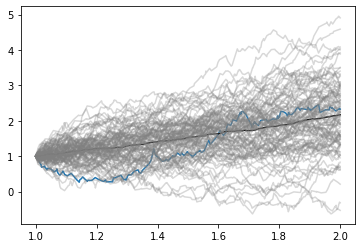

In [246]:
plt.plot(tou.pts.T, tou.trj.T)
tou_mle = tOU(t0 , t1, sample_mle, sigma.repeat(100, 1), init_dist=init_pts)
plt.plot(tou_mle.pts.T.mean(axis=1), tou_mle.trj.T.mean(axis=1), color='black')
plt.plot(tou_mle.pts.T, tou_mle.trj.T, color='grey', alpha=0.3)
plt.show()

In [247]:
for key in param_mle.keys():
    print(key + "    /  MLE: %.3f" % param_mle[key].item() + "    True: %.3f" % parameters[key].item())

a    /  MLE: 0.073    True: 0.050
b    /  MLE: -0.441    True: 0.800
c    /  MLE: 0.050    True: 0.050
d    /  MLE: 1.000    True: 1.000


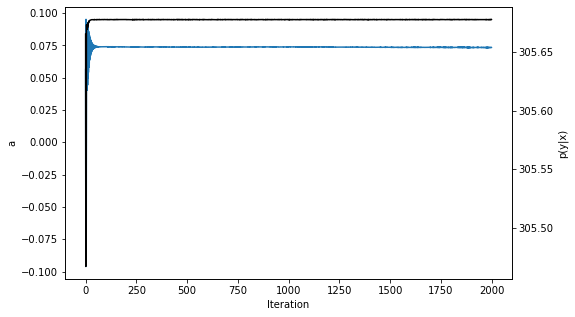

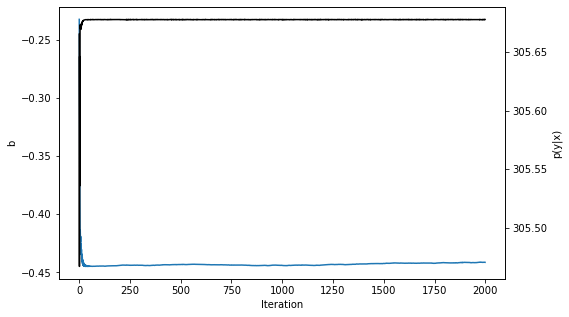

In [248]:
for key in paras_names:
    fig, ax = plt.subplots(figsize=(8,5))
    ax.plot(np.arange(len(param_hist[key])), param_hist[key])
    ax.set_ylabel(key)
    ax1 = ax.twinx()
    ax1.plot(np.arange(len(ll_hist)), ll_hist, color='black')
    
    ax.set_xlabel("Iteration")
    ax1.set_ylabel(r"p(y|x)")

Obtain variance parameter given mean parameters

In [249]:
paras_names = ['c', 'd']
init_pars = {key:torch.tensor([-1.0]).reshape(-1, 1) for key in paras_names}

In [250]:
for key in ['a', 'b']:
    init_pars[key] = parameters[key]

In [251]:
varP_mle, varP_hist, varLL_hist = MLE(tou.pts, tou.trj, sigma, dist, init_pars, paras_names, 2000, learning_rate=0.05)

LogLikelihood: tensor([301.0199])
LogLikelihood: tensor([305.9886])
LogLikelihood: tensor([306.1612])
LogLikelihood: tensor([306.2803])
LogLikelihood: tensor([306.3661])
LogLikelihood: tensor([306.4279])
LogLikelihood: tensor([306.4723])
LogLikelihood: tensor([306.5042])
LogLikelihood: tensor([306.5271])
LogLikelihood: tensor([306.5438])
LogLikelihood: tensor([306.5557])
LogLikelihood: tensor([306.5642])
LogLikelihood: tensor([306.5704])
LogLikelihood: tensor([306.5749])
LogLikelihood: tensor([306.5779])
LogLikelihood: tensor([306.5802])
LogLikelihood: tensor([306.5818])
LogLikelihood: tensor([306.5831])
LogLikelihood: tensor([306.5840])
LogLikelihood: tensor([306.5846])
LogLikelihood: tensor([306.5850])
LogLikelihood: tensor([306.5852])
LogLikelihood: tensor([306.5855])
LogLikelihood: tensor([306.5856])
LogLikelihood: tensor([306.5858])
LogLikelihood: tensor([306.5859])
LogLikelihood: tensor([306.5859])
LogLikelihood: tensor([306.5860])
LogLikelihood: tensor([306.5860])
LogLikelihood:

In [252]:
for key in varP_mle.keys():
    print(key + "    /  MLE: %.3f" % varP_mle[key].item() + "    True: %.3f" % parameters[key].item())

c    /  MLE: 4.691    True: 0.050
d    /  MLE: -0.942    True: 1.000
a    /  MLE: 0.050    True: 0.050
b    /  MLE: 0.800    True: 0.800


In [253]:
varSam_mle = {key: value.repeat(100, 1) for key,value in varP_mle.items()}

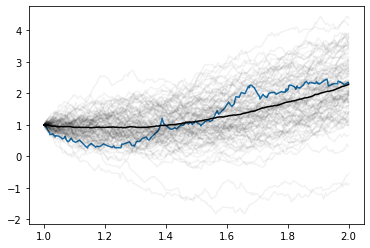

In [255]:
plt.plot(tou.pts.T, tou.trj.T)
tou_Varmle = tOU(t0 , t1, varSam_mle, sigma.repeat(100, 1), init_dist=init_pts)
plt.plot(tou_Varmle.pts.T.mean(axis=1), tou_Varmle.trj.T.mean(axis=1), color='black')
plt.plot(tou_Varmle.pts.T, tou_Varmle.trj.T, color='black', alpha=0.05)
plt.show()

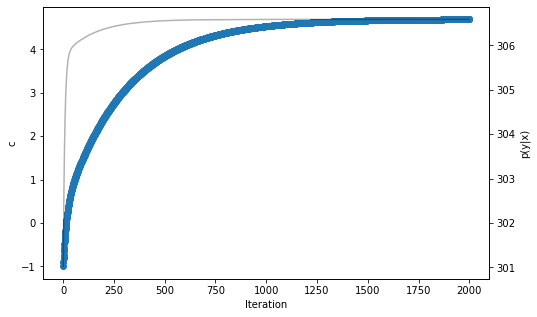

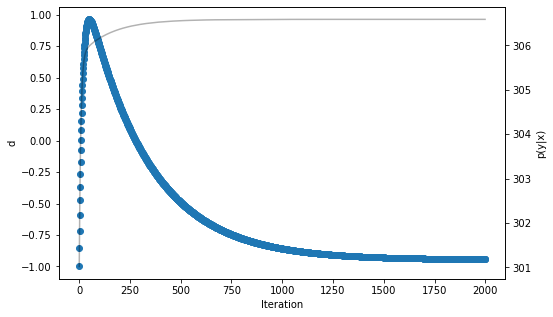

In [256]:
for key in paras_names:
    fig, ax = plt.subplots(figsize=(8,5))
    ax.scatter(np.arange(len(varP_hist[key])), varP_hist[key])
    ax.set_ylabel(key)
    ax1 = ax.twinx()
    ax1.plot(np.arange(len(varLL_hist)), varLL_hist, color='black', alpha=0.3)
    
    ax.set_xlabel("Iteration")
    ax1.set_ylabel(r"p(y|x)")

Obtain MLE for every parameter

In [276]:
paras_names = ['a', 'b', 'c', 'd']
init_pars = {key:torch.randn(1).reshape(-1, 1) + 2. for key in paras_names}

In [286]:
mle, pars, ll = MLE(tou.pts, tou.trj, sigma, dist, init_pars, paras_names, 5000, learning_rate=0.05)

LogLikelihood: tensor([304.4511])
LogLikelihood: tensor([306.6777])
LogLikelihood: tensor([307.1479])
LogLikelihood: tensor([309.7997])
LogLikelihood: tensor([309.8440])
LogLikelihood: tensor([309.6186])
LogLikelihood: tensor([309.8075])
LogLikelihood: tensor([309.8986])
LogLikelihood: tensor([309.7595])
LogLikelihood: tensor([309.3869])
LogLikelihood: tensor([309.9415])
LogLikelihood: tensor([309.6298])
LogLikelihood: tensor([310.0284])
LogLikelihood: tensor([309.5601])
LogLikelihood: tensor([310.0119])
LogLikelihood: tensor([310.0997])
LogLikelihood: tensor([310.0190])
LogLikelihood: tensor([310.0961])
LogLikelihood: tensor([310.0316])
LogLikelihood: tensor([310.1063])
LogLikelihood: tensor([310.0916])
LogLikelihood: tensor([310.1089])
LogLikelihood: tensor([310.0991])
LogLikelihood: tensor([310.0531])
LogLikelihood: tensor([310.0948])
LogLikelihood: tensor([310.0558])
LogLikelihood: tensor([310.0888])
LogLikelihood: tensor([310.0675])
LogLikelihood: tensor([310.0784])
LogLikelihood:

In [287]:
for key in mle.keys():
    print(key + "    /  MLE: %.3f" % mle[key].item() + "    True: %.3f" % parameters[key].item())

a    /  MLE: 8.402    True: 0.050
b    /  MLE: 0.358    True: 0.800
c    /  MLE: 2.081    True: 0.050
d    /  MLE: 3.022    True: 1.000


In [288]:
sample_mle = {key: value.repeat(100, 1) for key,value in mle.items()}

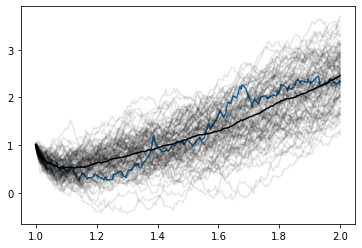

In [289]:
plt.plot(tou.pts.T, tou.trj.T)
tou_mle = tOU(t0 , t1, sample_mle, sigma.repeat(100, 1), init_dist=init_pts)
plt.plot(tou_mle.pts.T.mean(axis=1), tou_mle.trj.T.mean(axis=1), color='black')
plt.plot(tou_mle.pts.T, tou_mle.trj.T, color='black', alpha=0.1)
plt.show()

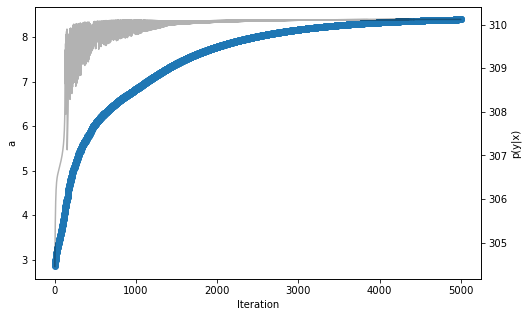

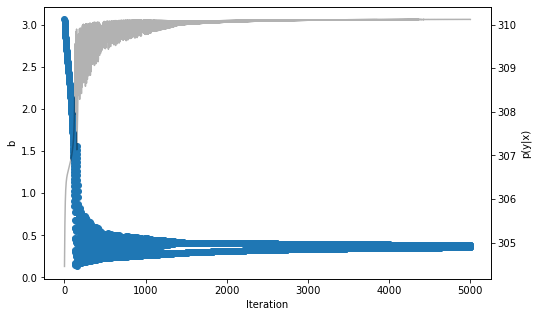

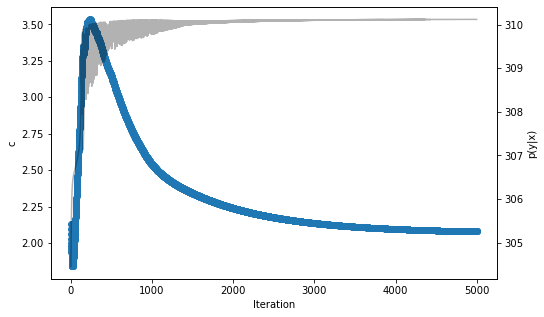

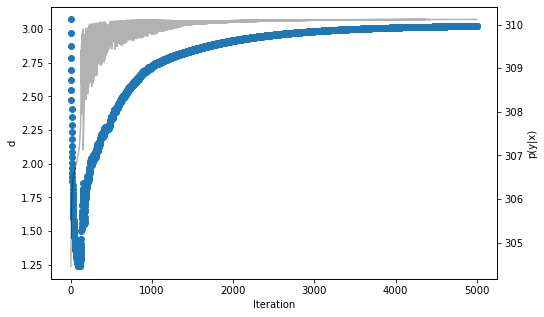

In [290]:
for key in paras_names:
    fig, ax = plt.subplots(figsize=(8,5))
    ax.scatter(np.arange(len(pars[key])), pars[key])
    ax.set_ylabel(key)
    ax1 = ax.twinx()
    ax1.plot(np.arange(len(ll)), ll, color='black', alpha=0.3)
    
    ax.set_xlabel("Iteration")
    ax1.set_ylabel(r"p(y|x)")